# Импорт библиотек

In [1]:
# !pip install keras-tuner

In [1]:
import pandas as pd
import numpy as np
import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from tensorflow.keras.utils import to_categorical

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

import torch
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from transformers import AdamW

from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import TFRobertaModel
from transformers import RobertaTokenizerFast
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification

from transformers import DebertaTokenizer
from transformers import DebertaForSequenceClassification

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow.python.keras.engine

Using TensorFlow backend


C:\Users\NeKonn\AppData\Local\Temp\ipykernel_13148\3288496659.py:37: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NeKonn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Загрузка данных

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

# Анализ данных

In [4]:
train_data.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
test_data.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


In [6]:
submission_data.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [7]:
# Проверка распределения столбца 'Sentiment' в тренировочном датасете
sentiment_distribution = train_data['Sentiment'].value_counts()
sentiment_distribution

Sentiment
Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [8]:
# Проверим наличие пропущенных значений в колонке "Text" обучающего и тестового набора данных
missing_train = train_data["Text"].isnull().sum()
missing_test = test_data["Text"].isnull().sum()

missing_train, missing_test

(1, 0)

In [9]:
# Удаление строк с пропущенными значениями
train_data = train_data.dropna(subset=["Text"])

# Предобработка данных

In [10]:
def preprocess_text(text):
    # Преобразование в нижний регистр
    text = text.lower()

    # Удаление эмодзи
    text = re.sub(r':\)|;\)|:-\)|\(-:|:-D|=D|:P|:p|:-p|:-b|:-O|:-/|:-\*|:D|:o|:\(|:-\(|:\'\(|:S|:-S|:\$|:@|8o\||8-\||\+o\(|<:-P|:-\||\^-^|\^-~|^_\^|,_,|o\.o|:@\]|:\^\)|:-c|:c|:-<|:\||:-\[|:-\*\*|:x|:-x|\>=\(|D:', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Удаление URL
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)  # Удаление ссылок и некоторых упоминаний

    # Удаление не-UTF символов
    text = re.sub(r'[^\x00-\x7f]', '', text)

    # Удаление знаков препинания и чисел
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Удаление хэштегов и символов
    waste_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans("", "", waste_list)
    text = text.translate(table)

    return text

# Предобработка текстовых данных
train_data["Processed_Text"] = train_data["Text"].apply(preprocess_text)
test_data["Processed_Text"] = test_data["Text"].apply(preprocess_text)

train_data[["Text", "Processed_Text"]].head()

,Text,Processed_Text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,and and
1,advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",me ready to go at supermarket during the covid...


In [11]:
# Функция для просмотра пропусков в данных
def check_missing_values(df):
    """
    Проверяет пропущенные значения в DataFrame и возвращает DataFrame с результатами.
    
    :param df: DataFrame для проверки
    :return: DataFrame с информацией о пропущенных значениях
    """
    # Вычисление количества пропущенных значений
    missing_values = df.isnull().sum()

    # Вычисление процента пропущенных значений
    missing_percentage = (missing_values / len(df)) * 100
    
    # Сборка нового DataFrame с информацией о пропущенных значениях
    missing_df = pd.DataFrame({
        'Columns': missing_values.index,
        'Missing Values Count': missing_values,
        'Missing Percentage (%)': missing_percentage
    }).reset_index(drop=True)
    
    # Возвращение результата
    return missing_df.sort_values(by='Missing Percentage (%)', ascending=False)
    
missing_data = check_missing_values(train_data)
missing_data

,Columns,Missing Values Count,Missing Percentage (%)
2,Sentiment,3,0.007289
0,Unnamed: 0,1,0.002430
1,Text,0,0.000000
3,Processed_Text,0,0.000000


In [12]:
# Удаляем пропущенные значения
train_data.dropna(inplace=True)

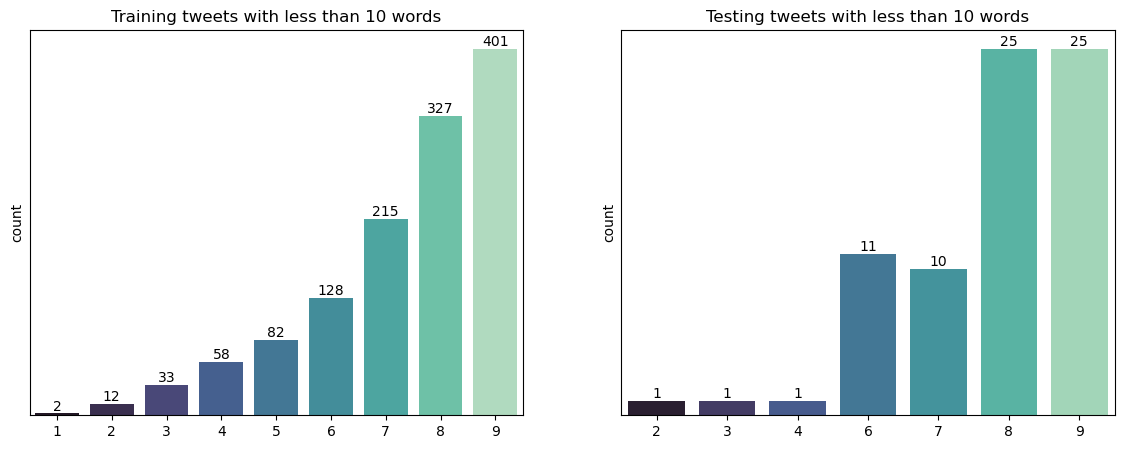

In [13]:
# Подсчет количества слов в каждом твите
train_data['text_len'] = train_data['Text'].apply(lambda x: len(x.split()))
test_data['text_len'] = test_data['Text'].apply(lambda x: len(x.split()))

# Построение графиков для твитов с менее чем 10 словами
def plot_text_length(train_data, test_data):
    plt.figure(figsize=(14,5))
    
    # Первый подграфик для обучающих данных
    plt.subplot(1, 2, 1)  # (rows, columns, panel number)
    ax1 = sns.countplot(x='text_len', data=train_data[train_data['text_len'] < 10], palette='mako')
    plt.title('Training tweets with less than 10 words')
    plt.yticks([])
    ax1.bar_label(ax1.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    
    # Второй подграфик для тестовых данных
    plt.subplot(1, 2, 2)
    ax2 = sns.countplot(x='text_len', data=test_data[test_data['text_len'] < 10], palette='mako')
    plt.title('Testing tweets with less than 10 words')
    plt.yticks([])
    ax2.bar_label(ax2.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    
    plt.show()

# Используем функцию для построения графиков для обучающих и тестовых данных
plot_text_length(train_data, test_data)

После проведения очистки некоторые твиты оказались без слов, что означает, что в них были только хэштеги, ссылки и так далее. Поэтому мы их удаляем, и для целей моделирования мы оставляем только те твиты, в которых больше 4 слов.

In [14]:
train_data = train_data[train_data['text_len'] > 4]
# test_data = test_data[test_data['text_len'] > 4]

In [15]:
# Инициализация токенизатора
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["Processed_Text"])

# Преобразование текста в последовательности чисел
train_sequences = tokenizer.texts_to_sequences(train_data["Processed_Text"])
test_sequences = tokenizer.texts_to_sequences(test_data["Processed_Text"])

# Определение максимальной длины последовательности
max_length = max([len(seq) for seq in train_sequences])

# Дополнение последовательностей до одной и той же длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_padded.shape, test_padded.shape

((41050, 62), (3798, 62))

In [16]:
stop_words = set(stopwords.words('english'))
# Удаление стоп-слов из токенизированных предложений
train_sentences = [[word for word in sentence if word not in stop_words] for sentence in train_padded]
test_sentences = [[word for word in sentence if word not in stop_words] for sentence in test_padded]

In [17]:
# Создаем словарь для перекодировки
sentiment_mapping = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

# Применяем этот словарь к столбцу Sentiment в обоих датасетах
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)

Class 0: 5480
Class 1: 9902
Class 2: 7651
Class 3: 11397
Class 4: 6620


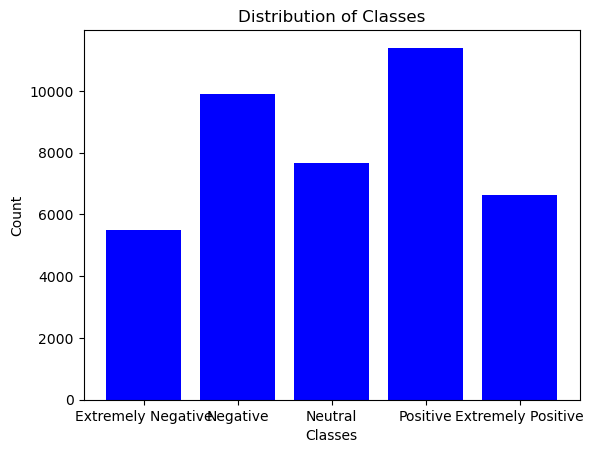

In [18]:
# Получаем уникальные классы и их количество
unique, counts = np.unique(train_data['Sentiment'], return_counts=True)

# Выведим распределение классов
for label, count in zip(unique, counts):
    print(f"Class {label}: {count}")

# Визуализация распределения классов
plt.bar(unique, counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(unique, ['Extremely Negative', 'Negative', 'Neutral', 'Positive','Extremely Positive'])  # устанавливаем названия для оси X
plt.show()

Мы видим, что у нас есть дисбаланс классов, поэтому используем Oversampling для борьбы с этим.

**Комментарий:** можно было бы воспользоваться библиотекой from imblearn.over_sampling import RandomOverSampler, но у меня возникает несовместимость, при попытках устранить, выдается еще больше ошибок. Чтобы не терять время на решение этой проблемы, ниже представлена функция, которая работает аналогичным образом.

In [20]:
# # Количество образцов для каждого класса
# class_counts = {
#     0: 5480,
#     1: 9902,
#     2: 7651,
#     3: 11397,
#     4: 6620
# }

# # Вычисление общего количества образцов
# total_samples = sum(class_counts.values())

# # Вычисление весов для каждого класса
# class_weights = {class_id: total_samples / count for class_id, count in class_counts.items()}
# class_weights

In [19]:
def oversample_data(df, target_col):
    # Определяем класс с максимальным количеством записей
    max_size = df[target_col].value_counts().max()

    # Создаем новый dataframe, который будет содержать наши перебалансированные данные
    balanced_df = pd.DataFrame()

    for class_name, group in df.groupby(target_col):
        # Для каждого класса дублируем записи, пока их количество не станет равным max_size
        balanced_group = group.sample(max_size, replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, balanced_group], axis=0)

    return balanced_df

train_data = oversample_data(train_data, 'Sentiment')
train_data['Sentiment'].value_counts()

Sentiment
0    11397
1    11397
2    11397
3    11397
4    11397
Name: count, dtype: int64

In [20]:
# Пересоздаем train_sequences и train_padded после oversampling
train_sequences = tokenizer.texts_to_sequences(train_data["Processed_Text"])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

# Построение RNN

In [23]:
# Разделение данных
x_train_valid = train_padded
y_train_valid = train_data['Sentiment'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, 
                                                    train_size=0.75, 
                                                    random_state=33)

In [24]:
# Уже определена максимальная длина последовательности
vocab_length = len(tokenizer.word_index) + 1

# Создание модели
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Конвертировать метки в категориальные
y_train = to_categorical(y_train, 5)
y_valid = to_categorical(y_valid, 5)

In [25]:
# Checkpoint для сохранения весов модели
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Обучение модели
num_epochs = 5
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_valid, y_valid), callbacks=[cp_callback])

# Визуализация результатов
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/5
1336/1336 [==============================] - ETA: 0s - loss: 1.2627 - accuracy: 0.4607
Epoch 1: saving model to training_1\cp.ckpt
1336/1336 [==============================] - 131s 96ms/step - loss: 1.2627 - accuracy: 0.4607 - val_loss: 0.9160 - val_accuracy: 0.6589
Epoch 2/5
1336/1336 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7442
Epoch 2: saving model to training_1\cp.ckpt
1336/1336 [==============================] - 169s 126ms/step - loss: 0.7093 - accuracy: 0.7442 - val_loss: 0.5849 - val_accuracy: 0.7916
Epoch 3/5
1336/1336 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8644
Epoch 3: saving model to training_1\cp.ckpt
1336/1336 [==============================] - 172s 129ms/step - loss: 0.4034 - accuracy: 0.8644 - val_loss: 0.4232 - val_accuracy: 0.8550
Epoch 4/5
1336/1336 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9152
Epoch 4: saving model to training_1\cp.ckpt
1336/1336 [===============

In [26]:
print(f"Accuracy on training data is: {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")
print(f"Accuracy on validation data is: {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

Accuracy on training data is: 94.39609050750732 %
Loss 17.848120629787445
Accuracy on validation data is: 88.55197429656982 %
Loss 39.11217153072357


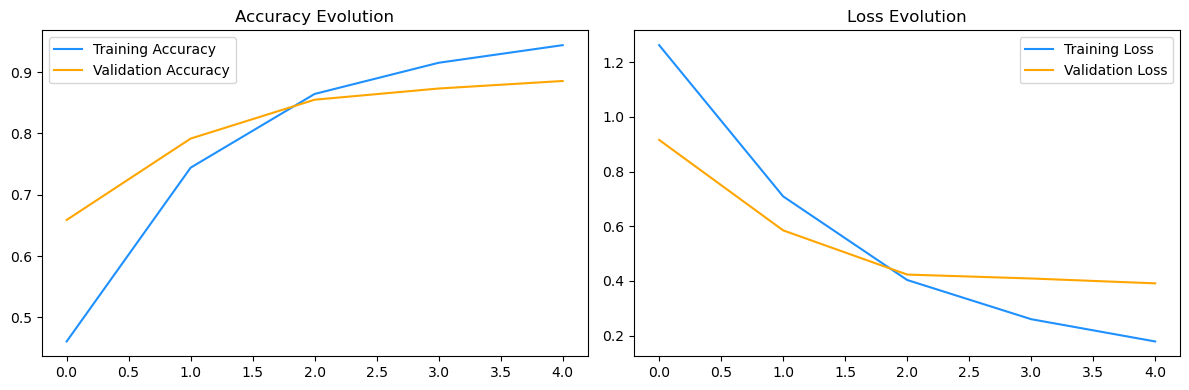

In [27]:
def plot_training_history(history):
    """
    Визуализация истории обучения модели.
    
    Параметры:
    - history: объект истории, возвращенный функцией model.fit().
    """
    plt.figure(figsize=(12, 4))
    epochs = range(len(history.history['accuracy']))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], color='dodgerblue', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')
    plt.savefig('accuracy.png')

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], color='dodgerblue', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], color='orange', label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')
    plt.savefig('loss.png')

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

In [28]:
# Оценка модели на валидационных данных
pred = model.predict(x_valid)
confusion_matrix(np.argmax(y_valid, 1), np.argmax(pred, 1))
print(classification_report(np.argmax(y_valid, 1), np.argmax(pred, 1)))

446/446 [==============================] - 9s 18ms/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2787
           1       0.80      0.86      0.83      2841
           2       0.95      0.83      0.89      2887
           3       0.84      0.84      0.84      2849
           4       0.93      0.94      0.93      2883

    accuracy                           0.89     14247
   macro avg       0.89      0.89      0.89     14247
weighted avg       0.89      0.89      0.89     14247



In [29]:
# Создаем словарь для обратного отображения
reverse_mapping = {v: k for k, v in sentiment_mapping.items()}

# Предсказание на тестовых данных
test_predictions = model.predict(test_padded)
test_predictions = test_predictions.argmax(axis=1)

# Обратное преобразование предсказанных меток в текстовые значения с использованием reverse_mapping
predicted_labels = [reverse_mapping[label] for label in test_predictions]

# Создание DataFrame для сохранения предсказаний
submission_data = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'Sentiment': predicted_labels
})

# Сохранение предсказаний в CSV файл
submission_data.to_csv('predictions.csv', index=False)

119/119 [==============================] - 2s 18ms/step


- Модель показывает хороший прогресс в процессе обучения. Точность на обучающем наборе данных увеличивается от 51% в начале до 94% к концу обучения, что говорит о том, что модель хорошо обучается и становится более уверенной в своих предсказаниях.

- Нет явных признаков переобучения. Это можно утверждать, так как точность на валидационном наборе также увеличивается (с 75% до 88%), и потери на валидации не начинают расти. В идеальном случае, потери на валидационном наборе должны уменьшаться вместе с потерями на обучающем наборе.

- Учитывая текущие результаты, можно рассмотреть возможность дальнейшего обучения модели на большем количестве эпох, так как точность продолжает расти. Однако следует следить за потерями и точностью на валидационной выборке, чтобы избежать переобучения.

- Точность на валидационном наборе данных составляет 88% после 5 эпох, что является весьма хорошим результатом.

### Подбор гипперпараметров

Для подбора гиперпараметров мы можем использовать GridSearchCV из sklearn или Hyperband из keras-tuner. Мы будем использовать Hyperband.

In [30]:
def build_model(hp):
    vocab_length = len(tokenizer.word_index) + 1

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_length, 
                                  hp.Int('embedding_dim', 8, 64, 4, default=16), 
                                  input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            hp.Int('gru_units', 128, 512, 64, default=256), return_sequences=True)),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(
            hp.Int('dense_units', 32, 128, 16, default=64), activation='relu'),
        tf.keras.layers.Dropout(
            hp.Float('dropout', 0, 0.5, 0.1, default=0.4)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4], default=1e-3)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Определение объекта tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    directory='hyperband',
    project_name='text_classification'
)

# Выполнение поиска
tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Reloading Tuner from hyperband\text_classification\tuner0.json


In [31]:
# Получение лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Вывод лучших гиперпараметров
print(f"""
Лучший размер вложения: {best_hps.get('embedding_dim')}
Лучшее количество блоков в LSTM: {best_hps.get('lstm_units')}  # замена на lstm_units
Лучший размер плотного слоя: {best_hps.get('dense_units')}
Лучший dropout: {best_hps.get('dropout')}
Лучший learning rate: {best_hps.get('learning_rate')}
""")


Лучший размер вложения: 32
Лучшее количество блоков в LSTM: 64  # замена на lstm_units
Лучший размер плотного слоя: 48
Лучший dropout: 0.0
Лучший learning rate: 0.005682201189419717



In [32]:
def build_model_with_params(hp=None):
    if hp is None:
        hp = {
            'embedding_dim': 16,
            'gru_units': 256,
            'dense_units': 64,
            'dropout': 0.4,
            'learning_rate': 1e-3
        }

    vocab_length = len(tokenizer.word_index) + 1

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_length, 
                                  hp['embedding_dim'] if isinstance(hp, dict) else hp.Int('embedding_dim', 8, 64, 4),
                                  input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
            hp['gru_units'] if isinstance(hp, dict) else hp.Int('gru_units', 128, 512, 64),
            return_sequences=True)),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(
            hp['dense_units'] if isinstance(hp, dict) else hp.Int('dense_units', 32, 128, 16),
            activation='relu'),
        tf.keras.layers.Dropout(
            hp['dropout'] if isinstance(hp, dict) else hp.Float('dropout', 0, 0.5, 0.1)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp['learning_rate'] if isinstance(hp, dict) else hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [33]:
fixed_model = build_model_with_params()

In [34]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    directory='hyperband',
    project_name='text_classification'
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Функция для расписания скорости обучения
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Выполнение поиска
tuner.search(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid), callbacks=[early_stop, lr_scheduler])

# Получение лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Построение модели с лучшими гиперпараметрами
best_model = tuner.hypermodel.build(best_hps)

# Обучение модели
history = best_model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), callbacks=[early_stop, lr_scheduler])

Reloading Tuner from hyperband\text_classification\tuner0.json
Epoch 1/10
1336/1336 [==============================] - 145s 106ms/step - loss: 0.7607 - accuracy: 0.7007 - val_loss: 0.4793 - val_accuracy: 0.8271 - lr: 0.0057
Epoch 2/10
1336/1336 [==============================] - 142s 106ms/step - loss: 0.3641 - accuracy: 0.8704 - val_loss: 0.4169 - val_accuracy: 0.8586 - lr: 0.0057
Epoch 3/10
1336/1336 [==============================] - 143s 107ms/step - loss: 0.2448 - accuracy: 0.9137 - val_loss: 0.4151 - val_accuracy: 0.8657 - lr: 0.0057
Epoch 4/10
1336/1336 [==============================] - 148s 111ms/step - loss: 0.2243 - accuracy: 0.9217 - val_loss: 0.5180 - val_accuracy: 0.8353 - lr: 0.0057
Epoch 5/10
1336/1336 [==============================] - 185s 139ms/step - loss: 0.4897 - accuracy: 0.8136 - val_loss: 0.9975 - val_accuracy: 0.5842 - lr: 0.0057


По результатам обучения видно, что наша модель быстро достигает высокой точности на тренировочных данных (accuracy: 0.9171), но точность на валидационных данных (val_accuracy: 0.8624) ниже. Переобучение начинается с 4 эпохи и сразу же останавливается обучение.

### Выводы по RNN
- Мы обучили рекурентную нейронную сеть и попытались улучшить результаты при помощи гипперпараметров. 
- Далее мы столкнулись с переобучением и в дальнейшем избавились от него при помощи методов:
1. увеличения drop rate
2. использования  learning rate schedule
3. введения batch normalizaion

В среднем наш accuracy на валидационной выборке достиг примерно 86%, что считается очень хорошим показателем в реальных условиях.

# Использование трансформеров

In [22]:
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [23]:
# Создание словаря для сопоставления меток с идентификаторами и наоборот
labels = train_data['Sentiment'].unique().tolist()
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Преобразование меток в идентификаторы
train_labels = train_data['Sentiment'].map(label_to_id).tolist()

# Разделение данных на обучающую и валидационную выборки
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42
)

# Токенизация после разделения
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

# Преобразование меток для val_data
val_labels = val_data['Sentiment'].map(label_to_id).tolist()

# Подготовка DataLoader
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [37]:
class EarlyStopping:
    """Ранняя остановка для прекращения обучения, если потери не улучшаются после определенного числа эпох."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): Как долго ждать после последнего времени улучшения. Default: 7.
            verbose (bool): Если True, выводит сообщение для каждого улучшения. Default: False.
            delta (float): Минимальное изменение для квалификации как улучшение. Default: 0.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Сохраняет модель, когда потери уменьшаются.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

**Комментарий:** Конечно, подобную реализацию ранней остановки было бы продуктивней вынести в отдельный .py файл, как скрипт и потом использовать его в качестве кастомной библиотеки, вызвав в соответствующем разделе `Импорт библиотек`, но в рамках учебного предоставления материалов, делать этого мы не будем, поэтому просто опишем данный класс тут и будем им пользоваться далее. 

Также по заданию необходимо было использовать lr-scheduler, что и продемонстрированно нами при построении трансформера.

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

Using device: cuda


In [39]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_to_id))
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Планировщик скорости обучения
scheduler = ExponentialLR(optimizer, gamma=0.1)

for epoch in range(3):
    model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Изменение скорости обучения
    scheduler.step()

    model.eval()
    val_loss = 0
    val_predictions = []
    true_labels = []
    for batch in val_loader:  # убедитесь, что у вас есть val_loader
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        val_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)

    # Вывод потерь на валидации
    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")

    # Сохранение чекпоинта после каждой эпохи
    torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


C:\Users\NeKonn\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 3206/3206 [08:05<00:00,  6.60it/s]


Validation Loss after Epoch 1: 0.4024


Training Epoch 2: 100%|██████████| 3206/3206 [08:04<00:00,  6.62it/s]


Validation Loss after Epoch 2: 0.3388


Training Epoch 3: 100%|██████████| 3206/3206 [08:04<00:00,  6.61it/s]


Validation Loss after Epoch 3: 0.3418


In [55]:
# Загрузка весов лучшей модели
model.load_state_dict(torch.load('checkpoint_epoch_2.pt'))  # или любой другой чекпоинт

# Вычисление точности на тренировочной выборке
model.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

train_accuracy = correct_predictions / total_predictions
print(f"Training Accuracy: {train_accuracy:.4f}")

# Вычисление точности на валидационной выборке
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

val_accuracy = correct_predictions / total_predictions
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.9217
Validation Accuracy: 0.8861


In [56]:
test_encodings = tokenizer(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

# Подготовка DataLoader для тестовых данных
test_dataset = TweetDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Загрузка весов лучшей модели
model.load_state_dict(torch.load('checkpoint_epoch_3.pt'))

# Получение предсказаний для тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        test_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

In [ ]:
id_to_label = {
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'
}

In [58]:
# Преобразование предсказанных идентификаторов обратно в метки
predicted_labels = [id_to_label[pred] for pred in test_predictions]

# Создание DataFrame для сохранения предсказаний
submission_data_3 = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'Sentiment': predicted_labels
})

# Сохранение предсказаний в CSV файл
submission_data_3.to_csv('predictions_3.csv', index=False)

# Пробуем модель Deberta

In [ ]:
from transformers import DebertaTokenizer, DebertaForSequenceClassification

# Использование DeBERTa токенизатора
tokenizer_deberta = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
train_encodings_deberta = tokenizer_deberta(train_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
test_encodings_deberta = tokenizer_deberta(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
val_encodings_deberta = tokenizer_deberta(val_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

# Подготовка DataLoader
train_dataset_deberta = TweetDataset(train_encodings_deberta, train_labels)
test_dataset_deberta = TweetDataset(test_encodings_deberta)
val_dataset_deberta = TweetDataset(val_encodings_deberta, val_labels)

train_loader_deberta = DataLoader(train_dataset_deberta, batch_size=16, shuffle=True)
test_loader_deberta = DataLoader(test_dataset_deberta, batch_size=16, shuffle=False)
val_loader_deberta = DataLoader(val_dataset_deberta, batch_size=16, shuffle=False)

model_deberta = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=len(label_to_id))
model_deberta.to(device)

optimizer_deberta = AdamW(model_deberta.parameters(), lr=1e-5)
scheduler_deberta = ExponentialLR(optimizer_deberta, gamma=0.1)

for epoch in range(3):
    model_deberta.train()
    for batch in tqdm(train_loader_deberta, desc=f"Training Epoch {epoch + 1}"):
        optimizer_deberta.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_deberta(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_deberta.step()

    # Изменение скорости обучения
    scheduler_deberta.step()

    model_deberta.eval()
    val_loss = 0
    val_predictions = []
    true_labels = []
    for batch in val_loader_deberta:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_deberta(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        val_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader_deberta)

    # Вывод потерь на валидации
    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")

    # Сохранение чекпоинта после каждой эпохи
    torch.save(model_deberta.state_dict(), f'deberta_checkpoint_epoch_{epoch+1}.pt')

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NeKonn\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 3206/3206 [08:30<00:00,  6.28it/s]


Validation Loss after Epoch 1: 0.4328


Training Epoch 2:  35%|███▍      | 1112/3206 [08:25<16:01,  2.18it/s]

In [ ]:
test_encodings_deberta = tokenizer_deberta(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

# Подготовка DataLoader для тестовых данных
test_dataset_deberta = TweetDataset(test_encodings_deberta)
test_loader_deberta = DataLoader(test_dataset_deberta, batch_size=16, shuffle=False)

# Загрузка весов лучшей модели
model_deberta.load_state_dict(torch.load('deberta_checkpoint_epoch_3.pt'))

# Получение предсказаний для тестовых данных
model_deberta.eval()
test_predictions_deberta = []
with torch.no_grad():
    for batch in test_loader_deberta:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model_deberta(input_ids, attention_mask=attention_mask)
        test_predictions_deberta.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Преобразование предсказанных идентификаторов обратно в метки
predicted_labels_deberta = [id_to_label[pred] for pred in test_predictions_deberta]

In [ ]:
# Создание DataFrame для сохранения предсказаний
submission_data_4 = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'Sentiment': predicted_labels_deberta
})

# Сохранение предсказаний в CSV файл
submission_data_4.to_csv('predictions_4.csv', index=False)

# Пробуем модель Roberta

In [ ]:
# Использование RoBERTa токенизатора
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings_roberta = tokenizer_roberta(train_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
test_encodings_roberta = tokenizer_roberta(test_data['Text'].tolist(), truncation=True, padding=True, max_length=256)
val_encodings_roberta = tokenizer_roberta(val_data['Text'].tolist(), truncation=True, padding=True, max_length=256)

# Подготовка DataLoader
train_dataset_roberta = TweetDataset(train_encodings_roberta, train_labels)
test_dataset_roberta = TweetDataset(test_encodings_roberta)
val_dataset_roberta = TweetDataset(val_encodings_roberta, val_labels)

train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=16, shuffle=True)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=16, shuffle=False)
val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=16, shuffle=False)

model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_to_id))
model_roberta.to(device)

optimizer_roberta = AdamW(model_roberta.parameters(), lr=1e-5)
scheduler_roberta = ExponentialLR(optimizer_roberta, gamma=0.1)

for epoch in range(3):
    model_roberta.train()
    for batch in tqdm(train_loader_roberta, desc=f"Training Epoch {epoch + 1}"):
        optimizer_roberta.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_roberta(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_roberta.step()

    # Изменение скорости обучения
    scheduler_roberta.step()

    model_roberta.eval()
    val_loss = 0
    val_predictions = []
    true_labels = []
    for batch in val_loader_roberta:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_roberta(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        val_predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader_roberta)

    # Вывод потерь на валидации
    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")

    # Сохранение чекпоинта после каждой эпохи
    torch.save(model_roberta.state_dict(), f'roberta_checkpoint_epoch_{epoch+1}.pt')

In [ ]:
# Загрузка весов лучшей модели
model_roberta.load_state_dict(torch.load('roberta_checkpoint_epoch_3.pt'))

# Получение предсказаний для тестовых данных
model_roberta.eval()
test_predictions_roberta = []
with torch.no_grad():
    for batch in test_loader_roberta:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model_roberta(input_ids, attention_mask=attention_mask)
        test_predictions_roberta.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Преобразование предсказанных идентификаторов обратно в метки
predicted_labels_roberta = [id_to_label[pred] for pred in test_predictions_roberta]

In [ ]:
# Создание DataFrame для сохранения предсказаний
submission_data_5 = pd.DataFrame({
    'id': test_data['id'],  # использование столбца 'id' из тестовых данных
    'Sentiment': predicted_labels_roberta
})

# Сохранение предсказаний в CSV файл
submission_data_5.to_csv('predictions_5.csv', index=False)

К сожалению, в связи с небольшим количеством GPU памяти на видеокарте, мне не хватило ресурсов, чтобы проверить оставшиеся модели, а ждать обучение по 3,5 часа на CPU банально не было времени. Для подобного просмотра нужны большие вычислительные мощности, которыми я не обладаю.

# Выводы: 
1. Была проведена предобработка данных, а также использован метод oversampling для балансировки таргета
2. В ходе данного задания мы обучили нейронную сеть, по результатам которой получили 0.79 score на соревновании kaggle 
3. Также была обучена модель трансформера, на основе BERT, по результатам которой получили 0.81 score на соревновании kaggle